In [92]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

import sys

Let's consider a simple paradigmatic model for a molecule. A two-level system coupled to a single harmonic oscillator in the so-called polaron frame. This model is the paradigm of an optomechanical description of a molecular electronic transition coupled to a vibrational mode.
The Hamiltonian is given by
$H = H_0 + H_D$,
where
$H_0 = \Delta \hat{\sigma}^{\dag}\hat{\sigma} + \omega_V \hat{b}^{\dag}\hat{b}$, and $H_D=\Omega_R(\hat{\sigma} e^{-\eta(\hat{b}-\hat{b}^{\dag})} + {\rm h.c.} )$.
The system is driven dissipative, so we treat it in master equation description. The TLS and vibrational dissipators are defined by their jump operators, given by $\lbrace{ \hat{\sigma},\, \hat{\sigma}^{\dag}\hat{\sigma},\, \hat{b} \rbrace}$, describing radiative loss, with rate $\gamma_{\rm rad}$, TLS dephasing, with rate $\gamma_{\rm deph}$, and vibrational loss $\gamma_{\rm v}$.
An eventual off-resonant pump is described by a pumping rate $\Gamma_+$, associated with a dissipator with jump operator $\hat{\sigma}^{\dag}$ (notice that, due to the hermitian conjugate, such term is not as previous radiative loss, since it does not relax toward the lowest energy state, but rather the highest energy level.)

We wrap up this model and we look for the steady state $\partial_t \hat{\rho}=0$. This can be efficiently computed by QuTip authomatically. We call the steady state density matrix $\hat{\rho}_{ss}$.
The fluorescence is given by ${\rm Fluo}=\gamma_{\rm rad}\langle{\hat{\sigma}^{\dag}\hat{\sigma} \rangle}$. Plotting this quantity as a function of the laser detuning $\Delta$ gives the excitation spectrum.
The fluorescence spectrum is instead given by $\mathcal{S}(\omega)=\int dt e^{i\omega t} \langle{\hat{\sigma}^{\dag}(t)\hat{\sigma} \rangle}$.
Notice that ${\rm Fluo}\sim \int d\omega \mathcal{S}(\omega)$, so the fluorescence rate is nothing else that the total fluorescence integrated over its spectrum.

In [112]:
#all frequencies in GHz
gamma_rad = 2*np.pi * 0.1    #radiative decay rate
gamma_deph = 2*np.pi * 0.      #dephasing rate

gamma_v = 2*np.pi * 1.      #vibrational decay rate
om_v = 2*np.pi * 10         #vibrational frequency
n_th = .1                    #possible vibrational thermal population

eta = 0.1                   #Franck-Condon factor

Om_R = 2*np.pi * .1         #Rabi frequency of external coherent drive

Nvib = 10                   #vibrational Hilbert space dimension
sig = tensor( sigmam(), qeye(Nvib)) #TLS annihilation operator
b = tensor(qeye(2), destroy(Nvib))  #vibrational annihilation operator
IDq = tensor(qeye(2), qeye(Nvib))   #identiy operator
sig_p = sig * tensor(qeye(2), displace(Nvib, eta))  #polaron dressed TLS annihilation operator

vDelta_opt = 2*np.pi * np.linspace(-40,40,300)  #vector containing all the detunings between coherent laser drive and the TLS central frequency
Fluo = np.zeros(len(vDelta_opt))                #vector where we store the resulting fluorescence rates
for nD, Delta_opt in enumerate(vDelta_opt):
    H0 = om_v*b.dag()*b + Delta_opt*sig.dag()*sig   #defining the Hamiltonian in the rotating frame
    HD = Om_R * ( sig_p + sig_p.dag() )

    c_jumps = [ gamma_rad**.5*sig_p, gamma_deph**.5*sig.dag()*sig, (gamma_v*(1+n_th))**.5*b, (gamma_v*(n_th))**.5*b.dag() ] #list of jump operators describing dissipations and dephasing

    rho_ss = steadystate(H0+HD, c_jumps)    #compute the steady state density matrix

    Fluo[nD] = expect(sig.dag()*sig, rho_ss)    #store the fluorescence rate

In [113]:
Gam_plus = 2*np.pi * .1     #off-resonant pumping rate (always in GHz)
c_jumps = [ gamma_rad**.5*sig_p, gamma_deph**.5*sig.dag()*sig, (gamma_v*(1+n_th))**.5*b, (gamma_v*(n_th))**.5*b.dag(), Gam_plus**.5*sig.dag() ] #list of jump operators describing dissipations and dephasing and off-res pump
H0 = om_v*b.dag()*b + 0*sig.dag()*sig   #defining the Hamiltonian in the rotating frame
rho_ss_off = steadystate(H0, c_jumps)

taulist = np.linspace(0, 10., 5000) #set the vector of times to compute the correlator g^1
C1 = correlation_2op_1t(H0, rho_ss_off, taulist, c_jumps, sig_p.dag(), sig_p, solver='me')# reverse=True)
wlist, S1 = spectrum_correlation_fft(taulist, C1)   #FFT of correlator to find spectrum

Text(0, 0.5, '$\\mathcal{S}(\\omega)$, Fluo$(\\omega)$')

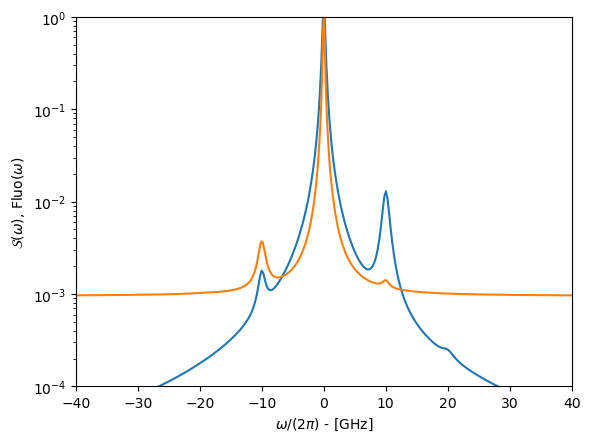

In [118]:
plt.plot(-vDelta_opt/(2*np.pi),Fluo/np.amax(Fluo))
plt.plot(wlist/(2*np.pi), (S1)/np.amax(S1) )
plt.yscale('log')
plt.ylim(1e-4,1e0)
plt.xlim(-40,40)
plt.xlabel(r"$\omega/(2\pi)$ - [GHz]")
plt.ylabel(r"$\mathcal{S}(\omega)$, Fluo$(\omega)$")